In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report, accuracy_score
from tabulate import tabulate
import joblib
from sklearn.ensemble import RandomForestClassifier

In [7]:
def print_avg_and_mean(dict):
    # Ponderado
    weighted_avg_precision = dict['weighted avg']['precision']
    weighted_avg_recall = dict['weighted avg']['recall']
    weighted_avg_f1_score = dict['weighted avg']['f1-score']
    weighted_avg_support = dict['weighted avg']['support']

    # Aritmético
    mean_precision = np.mean([dict[label]["precision"] for label in dict.keys() if label != "accuracy"])
    mean_recall = np.mean([dict[label]["recall"] for label in dict.keys() if label != "accuracy"]
    )
    mean_f1_score = np.mean([dict[label]["f1-score"] for label in dict.keys() if label != "accuracy"])
    mean_support = np.mean([dict[label]["support"] for label in dict.keys() if label != "accuracy"])

    print(f'Média Ponderada - Precisão: {weighted_avg_precision}')
    print(f'Média Ponderada - Recall: {weighted_avg_recall}')
    print(f'Média Ponderada - F1-Score: {weighted_avg_f1_score}')
    print(f'Média Ponderada - Support: {weighted_avg_support}')
    print('--------------------------------------------------')
    print(f'Média Aritmética - Precisão: {mean_precision}')
    print(f'Média Aritmética - Recall: {mean_recall}')
    print(f'Média Aritmética - F1-Score: {mean_f1_score}')
    print(f'Média Aritmética - Support: {mean_support}')

In [8]:
# Definindo o valor das seeds para garantir reprodutibilidade

RANDOM_SEED = 42

os.environ['PYTHONHASHSEED']=str(RANDOM_SEED)

random.seed(RANDOM_SEED)

np.random.seed(RANDOM_SEED)

In [9]:
# Carregar os dados de treino e teste
mitbih_train = pd.read_csv('mitbih_test.csv', header=None)
mitbih_test = pd.read_csv('mitbih_train.csv', header=None)

# Separar os conjuntos de treino e teste 
x_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

# Variáveis para teste e validação (50% teste - 50% validação)
X_test, X_val, y_test, y_val = train_test_split(
    mitbih_test.iloc[:, :-1].values, 
    mitbih_test.iloc[:, -1].values, 
    test_size=0.5, 
    random_state=RANDOM_SEED
)

In [10]:
# Treinamento do modelo
RandomForest = RandomForestClassifier(random_state=RANDOM_SEED)
RandomForest.fit(x_train, y_train)

# Previsão com base no conjunto de validação
y_pred_val = RandomForest.predict(X_val)

In [11]:
# Gerar relatório de classificação da Validação
report = classification_report(y_val, y_pred_val, target_names=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
print(f'Relatório de Classificação RandomForest (Validação):\n{report}')
cm = confusion_matrix(y_val, y_pred_val)

Relatório de Classificação RandomForest (Validação):
              precision    recall  f1-score   support

    Classe 1       0.97      1.00      0.98     36284
    Classe 2       0.97      0.55      0.70      1066
    Classe 3       0.96      0.84      0.90      2876
    Classe 4       0.96      0.47      0.63       324
    Classe 5       0.99      0.93      0.96      3227

    accuracy                           0.97     43777
   macro avg       0.97      0.76      0.83     43777
weighted avg       0.97      0.97      0.97     43777



Matriz de Confusão RandomForest (Validação):
[[36227    18    30     2     7]
 [  456   587    19     0     4]
 [  432     0  2419     5    20]
 [  141     1    30   152     0]
 [  215     1    13     0  2998]]


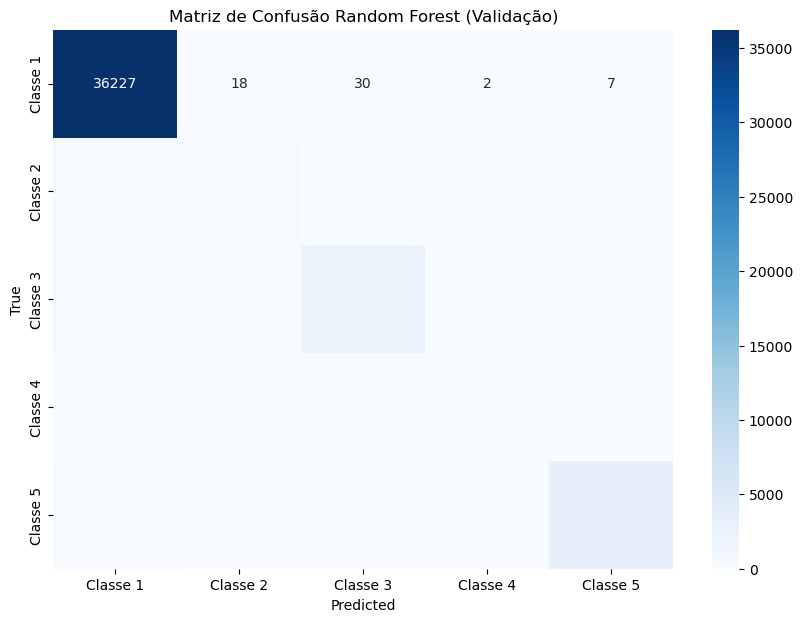

In [12]:
# Gerar e plotar a matriz de confusão da Validação
print(f'Matriz de Confusão RandomForest (Validação):\n{cm}')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão Random Forest (Validação)')
plt.show()

Grid Search em alguns parametros

In [13]:
# Definir o grid de hiperparâmetros para RandomForest
param_grid = {
    'n_estimators': list(range(1, 151)),  # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': [1, 2, 4],    # Número mínimo de amostras necessárias para estar em um nó folha
    'bootstrap': [True, False]        # Método para selecionar amostras para treinar cada árvore
}

In [ ]:
# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=RandomForest, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Executar o GridSearchCV no conjunto de teste
grid_search.fit(X_test, y_test)

Fitting 5 folds for each of 10800 candidates, totalling 54000 fits


In [ ]:
# Exibir os melhores parâmetros encontrados
print(f'Melhores hiperparâmetros: {grid_search.best_params_}')

# Treinar o modelo com os melhores parâmetros encontrados
best_rf = grid_search.best_estimator_

# Previsão com o modelo ajustado no conjunto de teste
y_pred_test = best_rf.predict(X_test)

In [ ]:
# Gerar relatório de classificação
report = classification_report(y_test, y_pred_test, target_names=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
print(f'Relatório de Classificação RandomForest (Teste):\n{report}')
cm = confusion_matrix(y_test, y_pred_test)

In [ ]:
# Gerar e plotar a matriz de confusão
print(f'Matriz de Confusão RandomForest (Teste):\n{cm}')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão Random Forest (Teste)')
plt.show()